In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/traffic.csv
/content/.config/.last_update_check.json
/content/.config/gce
/content/.config/active_config
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/default_configs.db
/content/.config/logs/2024.02.14/14.27.42.995136.log
/content/.config/logs/2024.02.14/14.27.50.504674.log
/content/.config/logs/2024.02.14/14.28.00.668277.log
/content/.config/logs/2024.02.14/14.27.33.851406.log
/content/.config/logs/2024.02.14/14.27.08.557557.log
/content/.config/logs/2024.02.14/14.27.59.896912.log
/content/.config/configurations/config_default
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv


In [6]:
!python --version

Python 3.10.12


In [7]:
data=pd.read_csv("/content/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [8]:
data['DateTime']=pd.to_datetime(data['DateTime'])

data["Year"]=data['DateTime'].dt.year

data["Month"]=data['DateTime'].dt.month

data["Date_no"]=data['DateTime'].dt.day

data["Hour"]=data['DateTime'].dt.hour

data["Day"]= data['DateTime'].dt.strftime("%A")

In [9]:
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


<Axes: xlabel='Date_no', ylabel='Vehicles'>

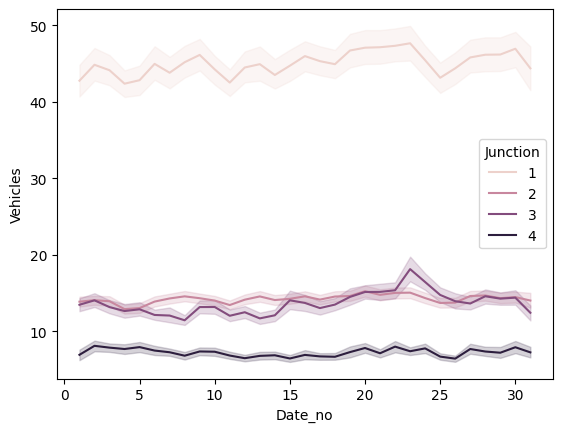

In [10]:
sns.lineplot(x=data['Date_no'],y="Vehicles",data=data,hue='Junction')

In [11]:
# data = data[(data['Junction'] == 1)]

In [12]:
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


In [13]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [14]:
df_N, av, std = Normalize(data, "Vehicles")
Diff = Difference(df_N, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N = df_N[24*7:]
df_N.columns = ["Norm"]
df_N["Diff"]= Diff

<ipython-input-14-25558da084e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N["Diff"]= Diff


In [15]:
df = df_N["Diff"].dropna()
df = df.to_frame()

In [16]:
df.head()

,Diff
168,-0.096385
169,0.144578
170,0.048193
171,0.048193
172,0.048193


In [17]:
df.shape

(47952, 1)

In [18]:
def Split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

df_train, df_test = Split_data(df)

In [19]:
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_train, y_train = TnF(df_train)
X_test, y_test = TnF(df_test)
X_train, X_test = FeatureFixShape(X_train, X_test)

In [20]:
from sklearn.metrics import mean_absolute_error

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The MAE is {}.".format(mae))
    return mae

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [21]:
Pred_MLP = MLP_model(X_train,y_train,X_test, y_test)

Epoch 1/50
320/320 [==============================] - 4s 4ms/step - loss: 0.0847 - val_loss: 0.1049
Epoch 2/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0685 - val_loss: 0.1002
Epoch 3/50
320/320 [==============================] - 1s 4ms/step - loss: 0.0646 - val_loss: 0.0982
Epoch 4/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0617 - val_loss: 0.0971
Epoch 5/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0625 - val_loss: 0.0969
Epoch 6/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0605 - val_loss: 0.0970
Epoch 7/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0604 - val_loss: 0.0970
Epoch 8/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0598 - val_loss: 0.0955
Epoch 9/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0601 - val_loss: 0.0954
Epoch 10/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0600 - val_loss: 0.0957

In [22]:
colors = ["#6D91A1","#74B3CE1","#536D7A","#3E535B"]

The root mean squared error is 0.3073375375717948.
The MAE is 0.16745914425451988.


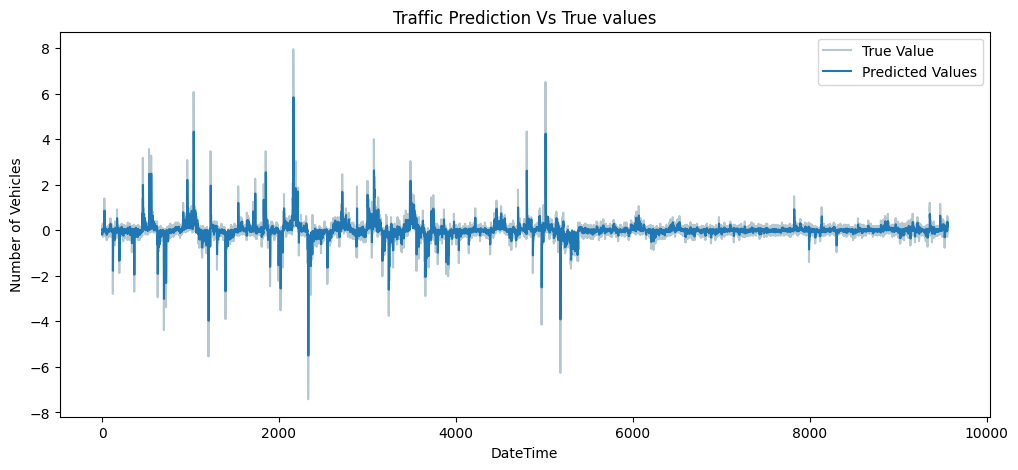

In [23]:
RMSE_MLP = RMSE_Value(y_test, Pred_MLP)
MAE_MLP = MAE_Value(y_test, Pred_MLP)
PredictionsPlot(y_test, Pred_MLP, 0)

In [24]:
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

def Sub_Plots(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True)
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#3E535B")
    axes[1].set(ylabel ="Original")

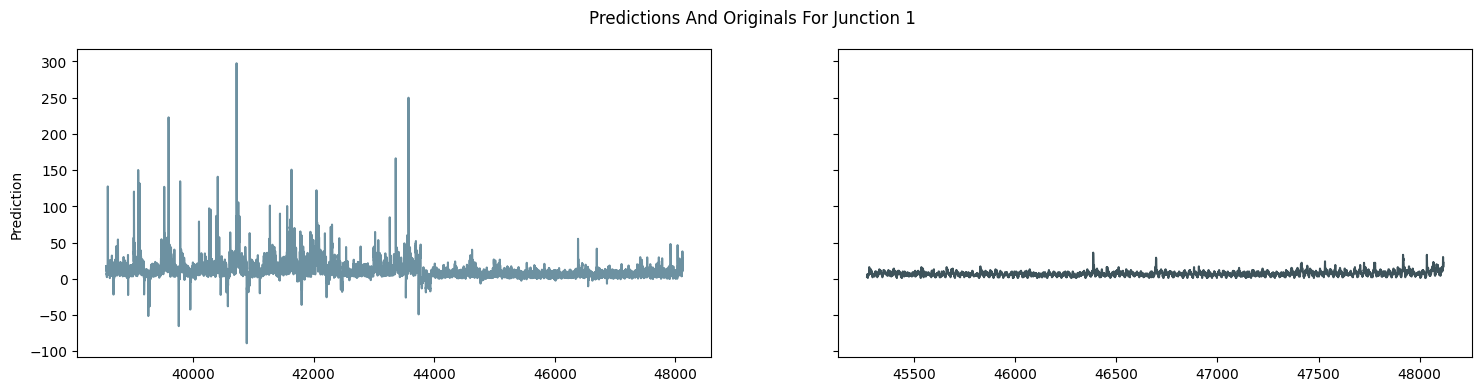

In [25]:
recover = df_N.Norm[-9560:-1].to_frame()
recover["Pred"]= globals()[f"Pred_MLP"]
Transform_reverssed = inverse_difference(recover.Norm, recover.Pred).to_frame()
Transform_reverssed.columns = ["Pred_Normed"]
Final_Pred = (Transform_reverssed.values* std) + av
Transform_reverssed["Pred_Final"] = Final_Pred
Sub_Plots(Transform_reverssed["Pred_Final"], data[-2854:-1],"Predictions And Originals For Junction 1", 0)

In [26]:
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning.

    #The GRU model
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

In [27]:
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

In [28]:
%time
Pred_GRU = GRU_model(X_train,y_train,X_test,y_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Epoch 1/50
320/320 [==============================] - 6s 9ms/step - loss: 0.0747 - val_loss: 0.1154
Epoch 2/50
320/320 [==============================] - 3s 8ms/step - loss: 0.0654 - val_loss: 0.1097
Epoch 3/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0624 - val_loss: 0.1078
Epoch 4/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0621 - val_loss: 0.1067
Epoch 5/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0609 - val_loss: 0.1064
Epoch 6/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0607 - val_loss: 0.1044
Epoch 7/50
320/320 [==============================] - 3s 8ms/step - loss: 0.0600 - val_loss: 0.1046
Epoch 8/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0605 - val_loss: 0.1029
Epoch 9/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0597 - val_loss: 0.1026
Epoch 10/50
320/320 [===============

The root mean squared error is 0.3186524602502865.
The MAE is 0.1752769610178566.


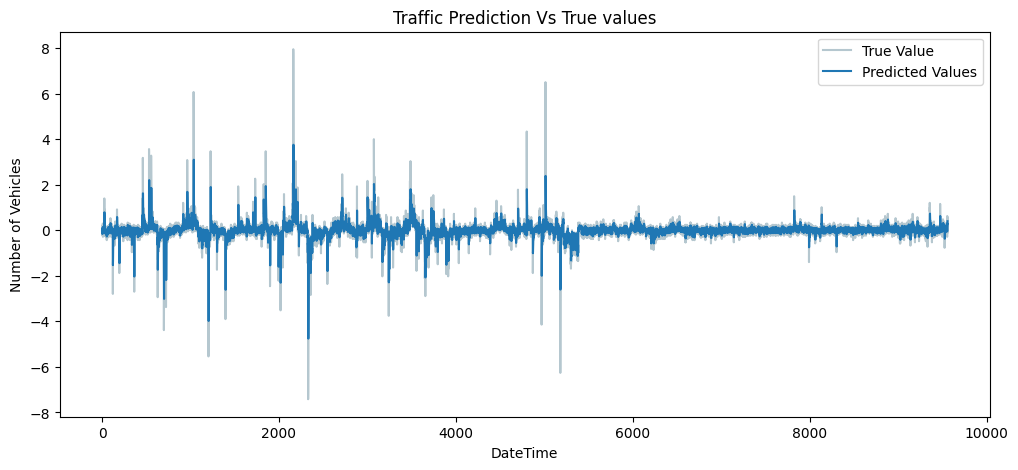

In [29]:
RMSE_GRU = RMSE_Value(y_test, Pred_GRU)
MAE_GRU = MAE_Value(y_test, Pred_GRU)
PredictionsPlot(y_test, Pred_GRU, 0)

In [30]:
Pred_LSTM = LSTM_model(X_train,y_train,X_test, y_test)

Epoch 1/50
320/320 [==============================] - 7s 10ms/step - loss: 0.0930 - val_loss: 0.1474
Epoch 2/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0787 - val_loss: 0.1373
Epoch 3/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0739 - val_loss: 0.1296
Epoch 4/50
320/320 [==============================] - 3s 8ms/step - loss: 0.0703 - val_loss: 0.1247
Epoch 5/50
320/320 [==============================] - 3s 9ms/step - loss: 0.0672 - val_loss: 0.1195
Epoch 6/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0645 - val_loss: 0.1178
Epoch 7/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0635 - val_loss: 0.1148
Epoch 8/50
320/320 [==============================] - 2s 8ms/step - loss: 0.0623 - val_loss: 0.1130
Epoch 9/50
320/320 [==============================] - 3s 9ms/step - loss: 0.0621 - val_loss: 0.1121
Epoch 10/50
320/320 [==============================] - 3s 9ms/step - loss: 0.0619 - val_loss: 0.110

The root mean squared error is 0.31566112791155965.
The MAE is 0.17386519642905848.


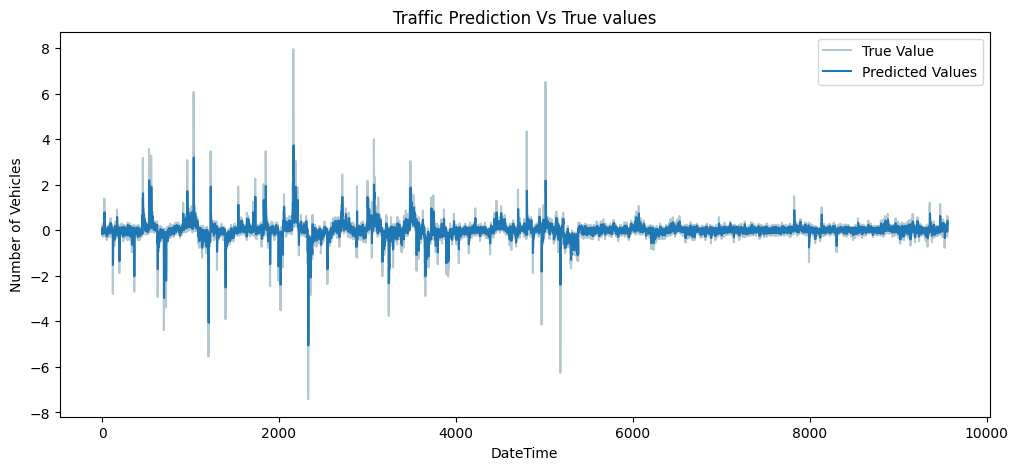

In [31]:
RMSE_LSTM = RMSE_Value(y_test, Pred_LSTM)
MAE_LSTM = MAE_Value(y_test, Pred_LSTM)
PredictionsPlot(y_test, Pred_LSTM, 0)